# Romanos NN
Neste notebook vamos treinar uma *Rede Neural* simples para converter números para algarismos romanos.

## Dataset
O dataset é uma tabela contendo **4999** algarismos romanos e seu correspondente em algarismos indo-arábicos.

In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
df = pd.read_csv("romanos.csv", sep="\t")
df.head()

,numero,romano
0,1,I
1,2,II
2,3,III
3,4,IV
4,5,V


In [3]:
df.tail()

,numero,romano
4994,4995,MMMMCMXCV
4995,4996,MMMMCMXCVI
4996,4997,MMMMCMXCVII
4997,4998,MMMMCMXCVIII
4998,4999,MMMMCMXCIX


## Preparação dos dados
O primeiro passo para treinar uma rede neural é a preparação de dados. Vamos criar `encodings` para a entrada e a saída dos dados.

A entrada de dados será uma array contendo o valor de cada número em binário (13 bits).

A saída de dados será uma array de 16 bytes contendo a string de saída (128 bits).

In [4]:
df.loc[df["romano"].apply(len).sort_values(ascending=False).index[0]]

numero                4888
romano    MMMMDCCCLXXXVIII
Name: 4887, dtype: object

In [5]:
def encode_in(row):
    R = [int(x) for x in bin(row)[2:]]
    R = [0] * (13 - len(R)) + R
    return R
    
df["in"] = df["numero"].apply(encode_in)
df.head()

,numero,romano,in
0,1,I,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
1,2,II,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
2,3,III,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]"
3,4,IV,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]"
4,5,V,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1]"


In [6]:
def decode_in(row):
    return int("".join([str(x) for x in row]), base=2)
    
all(df["in"].apply(decode_in) == df["numero"])

True

In [7]:
def encode_out(row):
    numerais = ["I", "V", "X", "L", "C", "D", "M", " "]
    zeros = np.zeros((16, len(numerais))).astype(np.uint8)
    R = list(row)
    R = [numerais.index(letra) for letra in R]
    R += [len(numerais)-1] * (16 - len(R))
    zeros[np.arange(16), R] = 1
    return zeros.flatten()
    
df["out"] = df["romano"].apply(encode_out)
df["out"].head()

0    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1    [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...
2    [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...
3    [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...
4    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: out, dtype: object

In [8]:
def decode_out(row):
    numerais = ["I", "V", "X", "L", "C", "D", "M", " "]
    return "".join([numerais[i] for i in row.reshape((16, -1)).argmax(axis=1)]).strip()

df["out"].apply(decode_out)
df["out"].head()

0    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1    [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...
2    [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...
3    [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...
4    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: out, dtype: object

Após a preparação dos dados, vamos dividir o dataset em dois conjuntos, o conjunto de treino contendo 80% dos dados e o conjunto de teste contendo 20% dos dados.

In [9]:
df_train, df_test = train_test_split(df, test_size=0.2)
df_train = df_train.reset_index().drop(columns="index")
df_test = df_test.reset_index().drop(columns="index")
print("treino:", len(df_train), "teste:", len(df_test))

treino: 3999 teste: 1000


In [10]:
print("conjunto de treino: {} linhas".format(len(df_train)))
df_train.head()

conjunto de treino: 3999 linhas


,numero,romano,in,out
0,130,CXXX,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
1,637,DCXXXVII,"[0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1]","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
2,4238,MMMMCCXXXVIII,"[1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, ..."
3,2757,MMDCCLVII,"[0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, ..."
4,46,XLVI,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0]","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."


In [11]:
print("conjunto de teste: {} linhas".format(len(df_test)))
df_test.head()

conjunto de teste: 1000 linhas


,numero,romano,in,out
0,4028,MMMMXXVIII,"[0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, ..."
1,1194,MCXCIV,"[0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, ..."
2,4605,MMMMDCV,"[1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, ..."
3,2007,MMVII,"[0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, ..."
4,4666,MMMMDCLXVI,"[1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, ..."


### Importante
- Extrair as características dos dados de entrada e saída;
- Separar os conjuntos de treino e de teste.

## Treinamento

As redes neurais realizam apenas três operações muito simples: 
  - MatMul;
  - Bias Add;
  - ACTIVATE!!!
  
![rede neural](Colored_neural_network.svg)

\begin{align}
\text{MatMul: }& h = W^t\cdotp X \\
\text{Bias Add: }& Z = W^t\cdotp X + b\\
\text{ACTIVATE!: }& A = f(W^t\cdotp X + b)\\
\end{align}

Para treinar uma rede, podemos comparar a saída da rede com a saída esperada e ajustar os pesos da matriz ***W*** e do vetor ***b*** de acordo com os erros. A técnica mais utilizada para isso é o **Backpropagation**.

Além disso, existem *otimizadores* que ajudam a manter a estabilidade do treino, além de diminuir o tempo necessário. Utilizaremos o **Adam** que ajusta alguns hiperparâmetros da rede automaticamente.

![adam](adam.png)

Com os dados prontos, podemos treinar as redes neurais. Vamos começar com uma rede pequena com apenas uma camada oculta:

In [12]:
model = Sequential()
model.add(Dense(units=64, activation='relu', input_dim=13))
model.add(Dense(units=128, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                896       
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
Total params: 9,216
Trainable params: 9,216
Non-trainable params: 0
_________________________________________________________________


A rede neural inicialmente "chuta" qualquer valor para a saída (acurácia ~50%). O texto gerado é aleatório.

In [13]:
def evaluate_model(model, df):
    res = model.evaluate(np.array(df["in"].values.tolist()), np.array(df["out"].values.tolist()))
    print("Custo: {}\nAcurácia: {}".format(*res))
evaluate_model(model, df_test)

1000/1000 [==============================] - 1s 892us/step
Custo: 0.704572901725769
Acurácia: 0.4820625


In [14]:
def make_predictions(model, df):
    pred = model.predict(np.array(df["in"].values.tolist()))
    data = []
    for (_, row), p in zip(df.iterrows(), pred):
        _p = decode_out(p)
        data.append({
            "numero": row["numero"],
            "romano": row["romano"],
            "pred": _p,
            "match": row["romano"] == _p
        })
    return pd.DataFrame(data)
def evaluate_algorisms(model, df):
    _df = make_predictions(model, df)
    acertos = _df["match"].sum()
    print(acertos, "acertos", round(acertos/len(_df)*100, 2), "%")
    return _df

df_p0 = evaluate_algorisms(model, df_test)
df_p0.head()

0 acertos 0.0 %


,match,numero,pred,romano
0,False,4028,VVCDCILCII CVL,MMMMXXVIII
1,False,1194,VCD VDLXDLDXLID,MCXCIV
2,False,4605,VICCCIVVL LLXDCL,MMMMDCV
3,False,2007,VICDC VMLCVVXMCX,MMVII
4,False,4666,VVCL I LLD VDMIL,MMMMDCLXVI


Treinando o modelo por uma época (todos os ~3999 algarismos) começamos a ver resultados mais coerentes:

In [15]:
history = model.fit(np.array(df_train["in"].values.tolist()), np.array(df_train["out"].values.tolist()), epochs=1, validation_split=0.1)

Instructions for updating:
Use tf.cast instead.
Train on 3599 samples, validate on 400 samples
Epoch 1/1
3599/3599 [==============================] - 0s 90us/step - loss: 0.3902 - acc: 0.8675 - val_loss: 0.1997 - val_acc: 0.9310


In [16]:
evaluate_model(model, df_test)

1000/1000 [==============================] - 0s 23us/step
Custo: 0.1972425116300583
Acurácia: 0.9322890625


In [17]:
df_p1 = evaluate_algorisms(model, df_test)
df_p1.head()

0 acertos 0.0 %


,match,numero,pred,romano
0,False,4028,MMMCCXX,MMMMXXVIII
1,False,1194,MMMCXX,MCXCIV
2,False,4605,MMMMCXX,MMMMDCV
3,False,2007,MMMCCXI,MMVII
4,False,4666,MMMMCXX,MMMMDCLXVI


#### Underfit!!!
Neste caso, o modelo entende a estrutura geral da saída (não separar os algarismos por exemplo), mas ainda não consegue prever os valores corretamente. Dizemos que esse modelo tem um grande viés, e está em regime de **underfit**.


## Treinando mais épocas
Vamos treinar o mesmo modelo por mais 499 épocas:

In [18]:
history = model.fit(np.array(df_train["in"].values.tolist()), np.array(df_train["out"].values.tolist()), epochs=499, validation_split=0.1)

Train on 3599 samples, validate on 400 samples
Epoch 1/499
3599/3599 [==============================] - 0s 56us/step - loss: 0.1875 - acc: 0.9327 - val_loss: 0.1786 - val_acc: 0.9352
Epoch 2/499
3599/3599 [==============================] - 0s 55us/step - loss: 0.1727 - acc: 0.9368 - val_loss: 0.1674 - val_acc: 0.9382
Epoch 3/499
3599/3599 [==============================] - 0s 55us/step - loss: 0.1624 - acc: 0.9394 - val_loss: 0.1600 - val_acc: 0.9391
Epoch 4/499
3599/3599 [==============================] - 0s 57us/step - loss: 0.1552 - acc: 0.9410 - val_loss: 0.1540 - val_acc: 0.9400
Epoch 5/499
3599/3599 [==============================] - 0s 61us/step - loss: 0.1502 - acc: 0.9415 - val_loss: 0.1500 - val_acc: 0.9404
Epoch 6/499
3599/3599 [==============================] - 0s 57us/step - loss: 0.1467 - acc: 0.9421 - val_loss: 0.1471 - val_acc: 0.9414
Epoch 7/499
3599/3599 [==============================] - 0s 56us/step - loss: 0.1439 - acc: 0.9429 - val_loss: 0.1445 - val_acc: 0.9413
E

3599/3599 [==============================] - 0s 53us/step - loss: 0.1066 - acc: 0.9558 - val_loss: 0.1117 - val_acc: 0.9532
Epoch 61/499
3599/3599 [==============================] - 0s 54us/step - loss: 0.1063 - acc: 0.9559 - val_loss: 0.1111 - val_acc: 0.9535
Epoch 62/499
3599/3599 [==============================] - 0s 53us/step - loss: 0.1060 - acc: 0.9560 - val_loss: 0.1110 - val_acc: 0.9535
Epoch 63/499
3599/3599 [==============================] - 0s 53us/step - loss: 0.1056 - acc: 0.9562 - val_loss: 0.1109 - val_acc: 0.9541
Epoch 64/499
3599/3599 [==============================] - 0s 54us/step - loss: 0.1054 - acc: 0.9563 - val_loss: 0.1105 - val_acc: 0.9532
Epoch 65/499
3599/3599 [==============================] - 0s 52us/step - loss: 0.1051 - acc: 0.9566 - val_loss: 0.1104 - val_acc: 0.9541
Epoch 66/499
3599/3599 [==============================] - 0s 53us/step - loss: 0.1048 - acc: 0.9566 - val_loss: 0.1097 - val_acc: 0.9540
Epoch 67/499
3599/3599 [==============================

Epoch 120/499
3599/3599 [==============================] - 0s 52us/step - loss: 0.0942 - acc: 0.9606 - val_loss: 0.1012 - val_acc: 0.9574
Epoch 121/499
3599/3599 [==============================] - 0s 54us/step - loss: 0.0940 - acc: 0.9607 - val_loss: 0.1012 - val_acc: 0.9573
Epoch 122/499
3599/3599 [==============================] - 0s 55us/step - loss: 0.0938 - acc: 0.9608 - val_loss: 0.1008 - val_acc: 0.9570
Epoch 123/499
3599/3599 [==============================] - 0s 54us/step - loss: 0.0937 - acc: 0.9607 - val_loss: 0.1008 - val_acc: 0.9572
Epoch 124/499
3599/3599 [==============================] - 0s 54us/step - loss: 0.0935 - acc: 0.9609 - val_loss: 0.1006 - val_acc: 0.9569
Epoch 125/499
3599/3599 [==============================] - 0s 54us/step - loss: 0.0934 - acc: 0.9609 - val_loss: 0.1004 - val_acc: 0.9573
Epoch 126/499
3599/3599 [==============================] - 0s 57us/step - loss: 0.0932 - acc: 0.9611 - val_loss: 0.1005 - val_acc: 0.9572
Epoch 127/499
3599/3599 [=========

3599/3599 [==============================] - 0s 53us/step - loss: 0.0864 - acc: 0.9641 - val_loss: 0.0939 - val_acc: 0.9603
Epoch 180/499
3599/3599 [==============================] - 0s 52us/step - loss: 0.0863 - acc: 0.9640 - val_loss: 0.0940 - val_acc: 0.9604
Epoch 181/499
3599/3599 [==============================] - 0s 52us/step - loss: 0.0861 - acc: 0.9642 - val_loss: 0.0939 - val_acc: 0.9605
Epoch 182/499
3599/3599 [==============================] - 0s 53us/step - loss: 0.0861 - acc: 0.9641 - val_loss: 0.0940 - val_acc: 0.9601
Epoch 183/499
3599/3599 [==============================] - 0s 54us/step - loss: 0.0859 - acc: 0.9643 - val_loss: 0.0940 - val_acc: 0.9606
Epoch 184/499
3599/3599 [==============================] - 0s 52us/step - loss: 0.0859 - acc: 0.9643 - val_loss: 0.0936 - val_acc: 0.9606
Epoch 185/499
3599/3599 [==============================] - 0s 55us/step - loss: 0.0857 - acc: 0.9643 - val_loss: 0.0934 - val_acc: 0.9605
Epoch 186/499
3599/3599 [=======================

3599/3599 [==============================] - 0s 53us/step - loss: 0.0813 - acc: 0.9662 - val_loss: 0.0898 - val_acc: 0.9627
Epoch 239/499
3599/3599 [==============================] - 0s 55us/step - loss: 0.0813 - acc: 0.9663 - val_loss: 0.0900 - val_acc: 0.9621
Epoch 240/499
3599/3599 [==============================] - 0s 54us/step - loss: 0.0811 - acc: 0.9663 - val_loss: 0.0898 - val_acc: 0.9628
Epoch 241/499
3599/3599 [==============================] - 0s 53us/step - loss: 0.0810 - acc: 0.9663 - val_loss: 0.0896 - val_acc: 0.9626
Epoch 242/499
3599/3599 [==============================] - 0s 53us/step - loss: 0.0810 - acc: 0.9666 - val_loss: 0.0897 - val_acc: 0.9626
Epoch 243/499
3599/3599 [==============================] - 0s 55us/step - loss: 0.0809 - acc: 0.9664 - val_loss: 0.0893 - val_acc: 0.9628
Epoch 244/499
3599/3599 [==============================] - 0s 53us/step - loss: 0.0808 - acc: 0.9665 - val_loss: 0.0893 - val_acc: 0.9630
Epoch 245/499
3599/3599 [=======================

3599/3599 [==============================] - 0s 54us/step - loss: 0.0775 - acc: 0.9679 - val_loss: 0.0863 - val_acc: 0.9639
Epoch 298/499
3599/3599 [==============================] - 0s 53us/step - loss: 0.0775 - acc: 0.9680 - val_loss: 0.0863 - val_acc: 0.9638
Epoch 299/499
3599/3599 [==============================] - 0s 53us/step - loss: 0.0774 - acc: 0.9679 - val_loss: 0.0863 - val_acc: 0.9640
Epoch 300/499
3599/3599 [==============================] - 0s 53us/step - loss: 0.0774 - acc: 0.9679 - val_loss: 0.0871 - val_acc: 0.9634
Epoch 301/499
3599/3599 [==============================] - 0s 54us/step - loss: 0.0773 - acc: 0.9680 - val_loss: 0.0861 - val_acc: 0.9639
Epoch 302/499
3599/3599 [==============================] - 0s 54us/step - loss: 0.0773 - acc: 0.9679 - val_loss: 0.0857 - val_acc: 0.9640
Epoch 303/499
3599/3599 [==============================] - 0s 54us/step - loss: 0.0773 - acc: 0.9678 - val_loss: 0.0863 - val_acc: 0.9640
Epoch 304/499
3599/3599 [=======================

3599/3599 [==============================] - 0s 55us/step - loss: 0.0749 - acc: 0.9688 - val_loss: 0.0846 - val_acc: 0.9642
Epoch 357/499
3599/3599 [==============================] - 0s 57us/step - loss: 0.0747 - acc: 0.9689 - val_loss: 0.0845 - val_acc: 0.9642
Epoch 358/499
3599/3599 [==============================] - 0s 55us/step - loss: 0.0747 - acc: 0.9688 - val_loss: 0.0844 - val_acc: 0.9643
Epoch 359/499
3599/3599 [==============================] - 0s 55us/step - loss: 0.0748 - acc: 0.9689 - val_loss: 0.0846 - val_acc: 0.9643
Epoch 360/499
3599/3599 [==============================] - 0s 52us/step - loss: 0.0747 - acc: 0.9689 - val_loss: 0.0842 - val_acc: 0.9644
Epoch 361/499
3599/3599 [==============================] - 0s 53us/step - loss: 0.0746 - acc: 0.9688 - val_loss: 0.0840 - val_acc: 0.9648
Epoch 362/499
3599/3599 [==============================] - 0s 54us/step - loss: 0.0746 - acc: 0.9690 - val_loss: 0.0844 - val_acc: 0.9646
Epoch 363/499
3599/3599 [=======================

3599/3599 [==============================] - 0s 53us/step - loss: 0.0728 - acc: 0.9696 - val_loss: 0.0826 - val_acc: 0.9651
Epoch 416/499
3599/3599 [==============================] - 0s 54us/step - loss: 0.0727 - acc: 0.9696 - val_loss: 0.0828 - val_acc: 0.9648
Epoch 417/499
3599/3599 [==============================] - 0s 52us/step - loss: 0.0728 - acc: 0.9696 - val_loss: 0.0826 - val_acc: 0.9649
Epoch 418/499
3599/3599 [==============================] - 0s 54us/step - loss: 0.0726 - acc: 0.9697 - val_loss: 0.0827 - val_acc: 0.9650
Epoch 419/499
3599/3599 [==============================] - 0s 53us/step - loss: 0.0726 - acc: 0.9697 - val_loss: 0.0828 - val_acc: 0.9651
Epoch 420/499
3599/3599 [==============================] - 0s 55us/step - loss: 0.0727 - acc: 0.9696 - val_loss: 0.0824 - val_acc: 0.9654
Epoch 421/499
3599/3599 [==============================] - 0s 52us/step - loss: 0.0725 - acc: 0.9697 - val_loss: 0.0825 - val_acc: 0.9653
Epoch 422/499
3599/3599 [=======================

3599/3599 [==============================] - 0s 53us/step - loss: 0.0711 - acc: 0.9704 - val_loss: 0.0817 - val_acc: 0.9659
Epoch 475/499
3599/3599 [==============================] - 0s 53us/step - loss: 0.0711 - acc: 0.9701 - val_loss: 0.0818 - val_acc: 0.9651
Epoch 476/499
3599/3599 [==============================] - 0s 53us/step - loss: 0.0711 - acc: 0.9702 - val_loss: 0.0810 - val_acc: 0.9654
Epoch 477/499
3599/3599 [==============================] - 0s 52us/step - loss: 0.0711 - acc: 0.9703 - val_loss: 0.0817 - val_acc: 0.9658
Epoch 478/499
3599/3599 [==============================] - 0s 53us/step - loss: 0.0712 - acc: 0.9702 - val_loss: 0.0811 - val_acc: 0.9654
Epoch 479/499
3599/3599 [==============================] - 0s 54us/step - loss: 0.0711 - acc: 0.9703 - val_loss: 0.0808 - val_acc: 0.9654
Epoch 480/499
3599/3599 [==============================] - 0s 54us/step - loss: 0.0710 - acc: 0.9703 - val_loss: 0.0808 - val_acc: 0.9656
Epoch 481/499
3599/3599 [=======================

In [19]:
evaluate_model(model, df_test)

1000/1000 [==============================] - 0s 19us/step
Custo: 0.07873558533191681
Acurácia: 0.96771875


In [20]:
df_p500 = evaluate_algorisms(model, df_test)
df_p500.head()

42 acertos 4.2 %


,match,numero,pred,romano
0,False,4028,MMMMXXXI,MMMMXXVIII
1,False,1194,MCCXII,MCXCIV
2,False,4605,MMMMDCI,MMMMDCV
3,False,2007,MMIX,MMVII
4,False,4666,MMMMDCLXII,MMMMDCLXVI


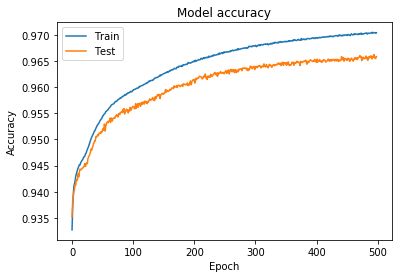

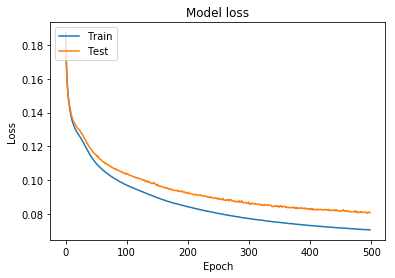

In [21]:
def plot_model(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
plot_model(history)

Treinando por mais épocas, conseguimos um modelo que entende o conceito dos algarismos, mas consegue prever corretamente menos 5% deles. Esse parece ser o limite dessa arquitetura.

## Segunda Tentativa
Como um modelo pequeno não foi capaz de generalizar o problema, vamos criar um modelo mais profundo (10 camadas ocultas):

In [22]:
model2 = Sequential()
model2.add(Dense(units=128, activation='relu', input_dim=13))
model2.add(Dense(units=128, activation='relu'))
model2.add(Dense(units=128, activation='relu'))
model2.add(Dense(units=128, activation='relu'))
model2.add(Dense(units=128, activation='relu'))
model2.add(Dense(units=128, activation='relu'))
model2.add(Dense(units=128, activation='relu'))
model2.add(Dense(units=128, activation='relu'))
model2.add(Dense(units=128, activation='relu'))
model2.add(Dense(units=128, activation='relu'))
model2.add(Dense(units=128, activation='sigmoid'))
model2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 128)               1792      
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_7 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_8 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_9 (Dense)              (None, 128)               16512     
__________

In [23]:
evaluate_model(model2, df_test)

1000/1000 [==============================] - 0s 132us/step
Custo: 0.6927651047706604
Acurácia: 0.536515625


In [24]:
df2_p0 = evaluate_algorisms(model2, df_test)
df2_p0.head()

0 acertos 0.0 %


,match,numero,pred,romano
0,False,4028,XLMXCCCMIMXXVXVI,MMMMXXVIII
1,False,1194,XLXXCCCMIMXXVXVI,MCXCIV
2,False,4605,LXXCCIMIMVXVXL,MMMMDCV
3,False,2007,XLMXCCCMIMVXVXL,MMVII
4,False,4666,XLMXCCIMIMVXVXL,MMMMDCLXVI


In [25]:
history2 = model2.fit(np.array(df_train["in"].values.tolist()), np.array(df_train["out"].values.tolist()), epochs=500, validation_split=0.1)

Train on 3599 samples, validate on 400 samples
Epoch 1/500
3599/3599 [==============================] - 1s 210us/step - loss: 0.2460 - acc: 0.9015 - val_loss: 0.1865 - val_acc: 0.9281
Epoch 2/500
3599/3599 [==============================] - 0s 117us/step - loss: 0.1866 - acc: 0.9288 - val_loss: 0.1863 - val_acc: 0.9291
Epoch 3/500
3599/3599 [==============================] - 0s 116us/step - loss: 0.1820 - acc: 0.9303 - val_loss: 0.1682 - val_acc: 0.9331
Epoch 4/500
3599/3599 [==============================] - 0s 112us/step - loss: 0.1522 - acc: 0.9381 - val_loss: 0.1420 - val_acc: 0.9386
Epoch 5/500
3599/3599 [==============================] - 0s 111us/step - loss: 0.1366 - acc: 0.9413 - val_loss: 0.1354 - val_acc: 0.9409
Epoch 6/500
3599/3599 [==============================] - 0s 114us/step - loss: 0.1307 - acc: 0.9437 - val_loss: 0.1322 - val_acc: 0.9426
Epoch 7/500
3599/3599 [==============================] - 0s 112us/step - loss: 0.1257 - acc: 0.9460 - val_loss: 0.1312 - val_acc: 0

3599/3599 [==============================] - 0s 109us/step - loss: 0.0538 - acc: 0.9755 - val_loss: 0.0804 - val_acc: 0.9662
Epoch 61/500
3599/3599 [==============================] - 0s 108us/step - loss: 0.0534 - acc: 0.9759 - val_loss: 0.0729 - val_acc: 0.9679
Epoch 62/500
3599/3599 [==============================] - 0s 110us/step - loss: 0.0547 - acc: 0.9753 - val_loss: 0.0795 - val_acc: 0.9670
Epoch 63/500
3599/3599 [==============================] - 0s 109us/step - loss: 0.0529 - acc: 0.9762 - val_loss: 0.0779 - val_acc: 0.9671
Epoch 64/500
3599/3599 [==============================] - 0s 111us/step - loss: 0.0530 - acc: 0.9758 - val_loss: 0.0744 - val_acc: 0.9693
Epoch 65/500
3599/3599 [==============================] - 0s 111us/step - loss: 0.0520 - acc: 0.9763 - val_loss: 0.0815 - val_acc: 0.9672
Epoch 66/500
3599/3599 [==============================] - 0s 110us/step - loss: 0.0510 - acc: 0.9767 - val_loss: 0.0754 - val_acc: 0.9678
Epoch 67/500
3599/3599 [=======================

3599/3599 [==============================] - 0s 111us/step - loss: 0.0416 - acc: 0.9810 - val_loss: 0.0768 - val_acc: 0.9695
Epoch 120/500
3599/3599 [==============================] - 0s 109us/step - loss: 0.0412 - acc: 0.9809 - val_loss: 0.0813 - val_acc: 0.9696
Epoch 121/500
3599/3599 [==============================] - 0s 109us/step - loss: 0.0415 - acc: 0.9811 - val_loss: 0.0847 - val_acc: 0.9694
Epoch 122/500
3599/3599 [==============================] - 0s 111us/step - loss: 0.0425 - acc: 0.9806 - val_loss: 0.0877 - val_acc: 0.9679
Epoch 123/500
3599/3599 [==============================] - 0s 110us/step - loss: 0.0438 - acc: 0.9801 - val_loss: 0.0817 - val_acc: 0.9695
Epoch 124/500
3599/3599 [==============================] - 0s 110us/step - loss: 0.0412 - acc: 0.9810 - val_loss: 0.0848 - val_acc: 0.9687
Epoch 125/500
3599/3599 [==============================] - 0s 108us/step - loss: 0.0414 - acc: 0.9811 - val_loss: 0.0830 - val_acc: 0.9694
Epoch 126/500
3599/3599 [================

3599/3599 [==============================] - 0s 108us/step - loss: 0.0315 - acc: 0.9860 - val_loss: 0.1092 - val_acc: 0.9671
Epoch 179/500
3599/3599 [==============================] - 0s 109us/step - loss: 0.0393 - acc: 0.9829 - val_loss: 0.0953 - val_acc: 0.9691
Epoch 180/500
3599/3599 [==============================] - 0s 109us/step - loss: 0.0339 - acc: 0.9851 - val_loss: 0.0991 - val_acc: 0.9682
Epoch 181/500
3599/3599 [==============================] - 0s 117us/step - loss: 0.0315 - acc: 0.9860 - val_loss: 0.1078 - val_acc: 0.9679
Epoch 182/500
3599/3599 [==============================] - 0s 113us/step - loss: 0.0311 - acc: 0.9861 - val_loss: 0.1057 - val_acc: 0.9689
Epoch 183/500
3599/3599 [==============================] - 0s 109us/step - loss: 0.0322 - acc: 0.9857 - val_loss: 0.1014 - val_acc: 0.9685
Epoch 184/500
3599/3599 [==============================] - 0s 110us/step - loss: 0.0302 - acc: 0.9866 - val_loss: 0.1080 - val_acc: 0.9691
Epoch 185/500
3599/3599 [================

3599/3599 [==============================] - 0s 111us/step - loss: 0.0231 - acc: 0.9901 - val_loss: 0.1267 - val_acc: 0.9694
Epoch 238/500
3599/3599 [==============================] - 0s 108us/step - loss: 0.0206 - acc: 0.9912 - val_loss: 0.1360 - val_acc: 0.9686
Epoch 239/500
3599/3599 [==============================] - 0s 111us/step - loss: 0.0208 - acc: 0.9913 - val_loss: 0.1389 - val_acc: 0.9680
Epoch 240/500
3599/3599 [==============================] - 0s 111us/step - loss: 0.0235 - acc: 0.9900 - val_loss: 0.1294 - val_acc: 0.9689
Epoch 241/500
3599/3599 [==============================] - 0s 108us/step - loss: 0.0225 - acc: 0.9905 - val_loss: 0.1327 - val_acc: 0.9683
Epoch 242/500
3599/3599 [==============================] - 0s 109us/step - loss: 0.0234 - acc: 0.9902 - val_loss: 0.1355 - val_acc: 0.9682
Epoch 243/500
3599/3599 [==============================] - 0s 108us/step - loss: 0.0236 - acc: 0.9901 - val_loss: 0.1362 - val_acc: 0.9675
Epoch 244/500
3599/3599 [================

3599/3599 [==============================] - 0s 108us/step - loss: 0.0170 - acc: 0.9929 - val_loss: 0.1651 - val_acc: 0.9675
Epoch 297/500
3599/3599 [==============================] - 0s 110us/step - loss: 0.0181 - acc: 0.9927 - val_loss: 0.1648 - val_acc: 0.9661
Epoch 298/500
3599/3599 [==============================] - 0s 110us/step - loss: 0.0219 - acc: 0.9912 - val_loss: 0.1573 - val_acc: 0.9679
Epoch 299/500
3599/3599 [==============================] - 0s 124us/step - loss: 0.0233 - acc: 0.9906 - val_loss: 0.1565 - val_acc: 0.9672
Epoch 300/500
3599/3599 [==============================] - 0s 119us/step - loss: 0.0182 - acc: 0.9928 - val_loss: 0.1599 - val_acc: 0.9679
Epoch 301/500
3599/3599 [==============================] - 0s 117us/step - loss: 0.0159 - acc: 0.9936 - val_loss: 0.1647 - val_acc: 0.9679
Epoch 302/500
3599/3599 [==============================] - 0s 116us/step - loss: 0.0161 - acc: 0.9934 - val_loss: 0.1597 - val_acc: 0.9695
Epoch 303/500
3599/3599 [================

3599/3599 [==============================] - 0s 111us/step - loss: 0.0138 - acc: 0.9946 - val_loss: 0.1826 - val_acc: 0.9673
Epoch 356/500
3599/3599 [==============================] - 0s 113us/step - loss: 0.0155 - acc: 0.9940 - val_loss: 0.1765 - val_acc: 0.9681
Epoch 357/500
3599/3599 [==============================] - 0s 115us/step - loss: 0.0131 - acc: 0.9950 - val_loss: 0.1905 - val_acc: 0.9664
Epoch 358/500
3599/3599 [==============================] - 0s 111us/step - loss: 0.0131 - acc: 0.9948 - val_loss: 0.1843 - val_acc: 0.9678
Epoch 359/500
3599/3599 [==============================] - 0s 110us/step - loss: 0.0107 - acc: 0.9959 - val_loss: 0.1951 - val_acc: 0.9675
Epoch 360/500
3599/3599 [==============================] - 0s 109us/step - loss: 0.0111 - acc: 0.9957 - val_loss: 0.1917 - val_acc: 0.9683
Epoch 361/500
3599/3599 [==============================] - 0s 111us/step - loss: 0.0104 - acc: 0.9960 - val_loss: 0.1944 - val_acc: 0.9677
Epoch 362/500
3599/3599 [================

3599/3599 [==============================] - 0s 109us/step - loss: 0.0063 - acc: 0.9977 - val_loss: 0.2155 - val_acc: 0.9681
Epoch 415/500
3599/3599 [==============================] - 0s 110us/step - loss: 0.0044 - acc: 0.9985 - val_loss: 0.2243 - val_acc: 0.9677
Epoch 416/500
3599/3599 [==============================] - 0s 109us/step - loss: 0.0049 - acc: 0.9982 - val_loss: 0.2291 - val_acc: 0.9677
Epoch 417/500
3599/3599 [==============================] - 0s 108us/step - loss: 0.0060 - acc: 0.9978 - val_loss: 0.2352 - val_acc: 0.9668
Epoch 418/500
3599/3599 [==============================] - 0s 111us/step - loss: 0.0147 - acc: 0.9947 - val_loss: 0.2272 - val_acc: 0.9650
Epoch 419/500
3599/3599 [==============================] - 0s 110us/step - loss: 0.0293 - acc: 0.9903 - val_loss: 0.1860 - val_acc: 0.9637
Epoch 420/500
3599/3599 [==============================] - 0s 111us/step - loss: 0.0206 - acc: 0.9922 - val_loss: 0.1819 - val_acc: 0.9663
Epoch 421/500
3599/3599 [================

Epoch 473/500
3599/3599 [==============================] - 0s 111us/step - loss: 0.0362 - acc: 0.9864 - val_loss: 0.1364 - val_acc: 0.9675
Epoch 474/500
3599/3599 [==============================] - 0s 109us/step - loss: 0.0182 - acc: 0.9931 - val_loss: 0.1576 - val_acc: 0.9681
Epoch 475/500
3599/3599 [==============================] - 0s 110us/step - loss: 0.0101 - acc: 0.9962 - val_loss: 0.1801 - val_acc: 0.9677
Epoch 476/500
3599/3599 [==============================] - 0s 110us/step - loss: 0.0063 - acc: 0.9978 - val_loss: 0.2011 - val_acc: 0.9679
Epoch 477/500
3599/3599 [==============================] - 0s 116us/step - loss: 0.0055 - acc: 0.9982 - val_loss: 0.2136 - val_acc: 0.9675
Epoch 478/500
3599/3599 [==============================] - 0s 111us/step - loss: 0.0054 - acc: 0.9982 - val_loss: 0.2166 - val_acc: 0.9676
Epoch 479/500
3599/3599 [==============================] - 0s 110us/step - loss: 0.0058 - acc: 0.9980 - val_loss: 0.2296 - val_acc: 0.9661
Epoch 480/500
3599/3599 [==

In [26]:
evaluate_model(model2, df_test)

1000/1000 [==============================] - 0s 23us/step
Custo: 0.16923495268821717
Acurácia: 0.9693984375


In [27]:
df2_p500 = evaluate_algorisms(model2, df_test)
df2_p500.head()

57 acertos 5.7 %


,match,numero,pred,romano
0,False,4028,MMMMXXVI,MMMMXXVIII
1,False,1194,MCXCIX,MCXCIV
2,False,4605,MMMMDCI,MMMMDCV
3,False,2007,MMXII,MMVII
4,True,4666,MMMMDCLXVI,MMMMDCLXVI


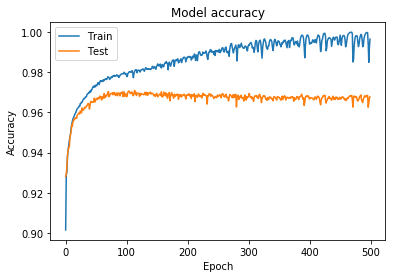

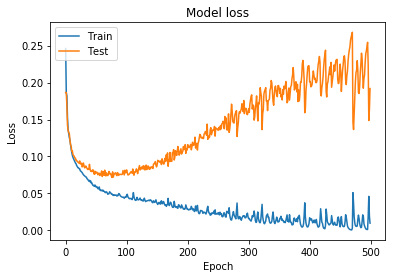

In [28]:
plot_model(history2)

#### Overfit!!
Dessa vez o modelo consegue acertar todo o conjunto de treino mas não o conjunto de testes, o modelo apenas decorou os algarismos do conjunto de treino mas não consegue generalizar o problema. Dizemos que esse modelo possui uma grande variância e está em regime de **overfit**.

## Terceira tentativa
Por último, vamos tentar uma rede com 4 camadas ocultas, mas com mais nós em cada camada para extrair mais características.

In [29]:
model3 = Sequential()
model3.add(Dense(units=1024, activation='relu', input_dim=13))
model3.add(Dense(units=512, activation='relu'))
model3.add(Dense(units=256, activation='relu'))
model3.add(Dense(units=128, activation='sigmoid'))
model3.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 1024)              14336     
_________________________________________________________________
dense_15 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_16 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_17 (Dense)             (None, 128)               32896     
Total params: 703,360
Trainable params: 703,360
Non-trainable params: 0
_________________________________________________________________


In [30]:
history3 = model3.fit(np.array(df_train["in"].values.tolist()), np.array(df_train["out"].values.tolist()), epochs=120, validation_split=0.1)

Train on 3599 samples, validate on 400 samples
Epoch 1/120
3599/3599 [==============================] - 1s 189us/step - loss: 0.2143 - acc: 0.9220 - val_loss: 0.1494 - val_acc: 0.9395
Epoch 2/120
3599/3599 [==============================] - 0s 97us/step - loss: 0.1356 - acc: 0.9438 - val_loss: 0.1301 - val_acc: 0.9442
Epoch 3/120
3599/3599 [==============================] - 0s 97us/step - loss: 0.1225 - acc: 0.9498 - val_loss: 0.1195 - val_acc: 0.9505
Epoch 4/120
3599/3599 [==============================] - 0s 96us/step - loss: 0.1114 - acc: 0.9540 - val_loss: 0.1106 - val_acc: 0.9529
Epoch 5/120
3599/3599 [==============================] - 0s 97us/step - loss: 0.1039 - acc: 0.9564 - val_loss: 0.1059 - val_acc: 0.9552
Epoch 6/120
3599/3599 [==============================] - 0s 98us/step - loss: 0.0986 - acc: 0.9584 - val_loss: 0.1023 - val_acc: 0.9554
Epoch 7/120
3599/3599 [==============================] - 0s 98us/step - loss: 0.0944 - acc: 0.9602 - val_loss: 0.0994 - val_acc: 0.9574


3599/3599 [==============================] - 0s 101us/step - loss: 0.0147 - acc: 0.9945 - val_loss: 0.0469 - val_acc: 0.9831
Epoch 61/120
3599/3599 [==============================] - 0s 116us/step - loss: 0.0168 - acc: 0.9934 - val_loss: 0.0545 - val_acc: 0.9813
Epoch 62/120
3599/3599 [==============================] - 0s 115us/step - loss: 0.0160 - acc: 0.9937 - val_loss: 0.0461 - val_acc: 0.9837
Epoch 63/120
3599/3599 [==============================] - 0s 104us/step - loss: 0.0126 - acc: 0.9955 - val_loss: 0.0462 - val_acc: 0.9841
Epoch 64/120
3599/3599 [==============================] - 0s 122us/step - loss: 0.0137 - acc: 0.9947 - val_loss: 0.0467 - val_acc: 0.9835
Epoch 65/120
3599/3599 [==============================] - 0s 121us/step - loss: 0.0124 - acc: 0.9955 - val_loss: 0.0465 - val_acc: 0.9837
Epoch 66/120
3599/3599 [==============================] - 0s 102us/step - loss: 0.0119 - acc: 0.9957 - val_loss: 0.0520 - val_acc: 0.9820
Epoch 67/120
3599/3599 [=======================

3599/3599 [==============================] - 0s 95us/step - loss: 3.2953e-04 - acc: 1.0000 - val_loss: 0.0637 - val_acc: 0.9859
Epoch 120/120
3599/3599 [==============================] - 0s 99us/step - loss: 3.1214e-04 - acc: 1.0000 - val_loss: 0.0644 - val_acc: 0.9858


In [31]:
evaluate_model(model3, df_test)

1000/1000 [==============================] - 0s 25us/step
Custo: 0.06019114553928375
Acurácia: 0.9866640625


In [32]:
df3_p120 = evaluate_algorisms(model3, df_test)
df3_p120.head()

436 acertos 43.6 %


,match,numero,pred,romano
0,False,4028,MMMMXXIII,MMMMXXVIII
1,False,1194,MCXCV,MCXCIV
2,False,4605,MMMMDC,MMMMDCV
3,False,2007,MMVI,MMVII
4,True,4666,MMMMDCLXVI,MMMMDCLXVI


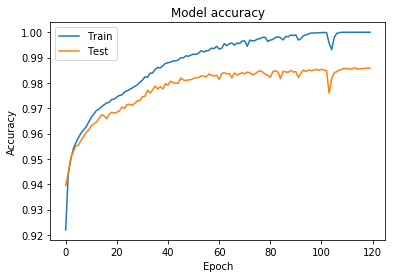

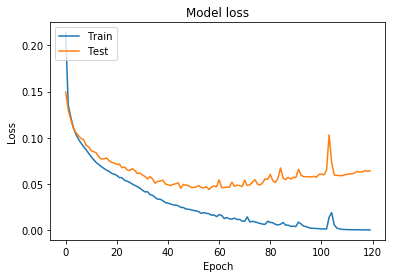

In [33]:
plot_model(history3)

#### Certin!!!
Encontrar os parâmetros ótimos para cada problema é um processo iterativo e requer paciência e experiência.

## Importante
- Cada "neurônio" é muito simples (MatMul, Bias Add, ACTIVATE!);
- Backpropagation;
- Escolha da arquitetura e hiperparâmetros (camadas, ativações, otimizador);
- **Escolha do custo**;

In [34]:
def predict(n):
    n_enc = encode_in(n)
    print("encode n: {}".format(n_enc))
    pred = model3.predict(np.array([n_enc]))
    print("pred enc_n: {}".format(pred.round(3).reshape((16, -1))))
    out = decode_out(pred)
    print("decode pred: {}".format(out))
    return out
predict(700)

encode n: [0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0]
pred enc_n: [[0.    0.    0.    0.    0.    1.    0.    0.   ]
 [0.    0.    0.    0.    1.    0.    0.    0.   ]
 [0.    0.    0.    0.    1.    0.    0.    0.   ]
 [0.001 0.    0.    0.    0.001 0.    0.    1.   ]
 [0.    0.002 0.    0.    0.    0.    0.    1.   ]
 [0.    0.    0.    0.    0.    0.    0.    1.   ]
 [0.    0.    0.    0.    0.    0.    0.    1.   ]
 [0.    0.    0.    0.    0.    0.    0.    1.   ]
 [0.    0.    0.    0.    0.    0.    0.    1.   ]
 [0.    0.    0.    0.    0.    0.    0.    1.   ]
 [0.    0.    0.    0.    0.    0.    0.    1.   ]
 [0.    0.    0.    0.    0.    0.    0.    1.   ]
 [0.    0.    0.    0.    0.    0.    0.    1.   ]
 [0.    0.    0.    0.    0.    0.    0.    1.   ]
 [0.    0.    0.    0.    0.    0.    0.    1.   ]
 [0.    0.    0.    0.    0.    0.    0.    1.   ]]
decode pred: DCC


'DCC'

## Shhhh 🤫 Último modelo

Conhecimento de domínio pode auxiliar muito no treinamento dos modelos. Sabendo que a base dos algorítmos romanos é decimal, podemos passar os dígitos de entrada com um `encoding` decimal:

In [35]:
def encode_in(row):
    zeros = np.zeros((4, 10)).astype(np.uint8)
    R = [int(c) for c in str(row).zfill(4)]
    zeros[np.arange(4), R] = 1
    return zeros.flatten()

df["in"] = df["numero"].apply(encode_in)
df["in"].head()

0    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...
1    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...
2    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...
3    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...
4    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...
Name: in, dtype: object

In [36]:
df.loc[77]["in"]

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], dtype=uint8)

In [37]:
def decode_in(row):
    return int("".join([str(np.argmax(line)) for line in row.reshape(4, 10)]))

df["in"].apply(decode_in)
df["in"].apply(decode_in) == df["numero"]
all(df["in"].apply(decode_in) == df["numero"])

True

In [38]:
df_train, df_test = train_test_split(df, test_size=0.6)
df_train = df_train.reset_index().drop(columns="index")
df_test = df_test.reset_index().drop(columns="index")
print("treino:", len(df_train), "teste:", len(df_test))

treino: 1999 teste: 3000


In [39]:
model4 = Sequential()
model4.add(Dense(units=64, activation='relu', input_dim=40))
model4.add(Dense(units=128, activation='sigmoid'))
model4.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=0.01
                             , beta_1=0.5, beta_2=0.9),
              metrics=['accuracy'])
model4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 64)                2624      
_________________________________________________________________
dense_19 (Dense)             (None, 128)               8320      
Total params: 10,944
Trainable params: 10,944
Non-trainable params: 0
_________________________________________________________________


In [40]:
history4 = model4.fit(np.array(df_train["in"].values.tolist()), np.array(df_train["out"].values.tolist()), epochs=50, validation_split=0.1)

Train on 1799 samples, validate on 200 samples
Epoch 1/50
1799/1799 [==============================] - 0s 216us/step - loss: 0.2037 - acc: 0.9278 - val_loss: 0.1098 - val_acc: 0.9572
Epoch 2/50
1799/1799 [==============================] - 0s 61us/step - loss: 0.0934 - acc: 0.9625 - val_loss: 0.0814 - val_acc: 0.9675
Epoch 3/50
1799/1799 [==============================] - 0s 64us/step - loss: 0.0745 - acc: 0.9687 - val_loss: 0.0690 - val_acc: 0.9708
Epoch 4/50
1799/1799 [==============================] - 0s 64us/step - loss: 0.0633 - acc: 0.9729 - val_loss: 0.0606 - val_acc: 0.9742
Epoch 5/50
1799/1799 [==============================] - 0s 61us/step - loss: 0.0543 - acc: 0.9771 - val_loss: 0.0516 - val_acc: 0.9780
Epoch 6/50
1799/1799 [==============================] - 0s 61us/step - loss: 0.0470 - acc: 0.9807 - val_loss: 0.0465 - val_acc: 0.9798
Epoch 7/50
1799/1799 [==============================] - 0s 58us/step - loss: 0.0410 - acc: 0.9837 - val_loss: 0.0407 - val_acc: 0.9829
Epoch 8

In [41]:
evaluate_model(model4, df_test)

3000/3000 [==============================] - 0s 21us/step
Custo: 0.007566266352931658
Acurácia: 0.9976796876589458


In [42]:
df4_p50 = evaluate_algorisms(model4, df_test)
df4_p50.head()

2840 acertos 94.67 %


,match,numero,pred,romano
0,True,3960,MMMCMLX,MMMCMLX
1,True,3919,MMMCMXIX,MMMCMXIX
2,True,1211,MCCXI,MCCXI
3,True,2489,MMCDLXXXIX,MMCDLXXXIX
4,True,1290,MCCXC,MCCXC


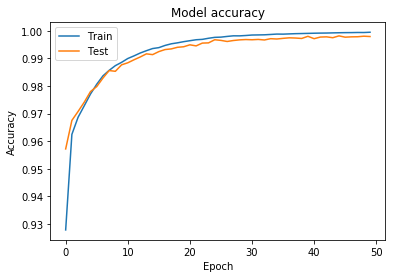

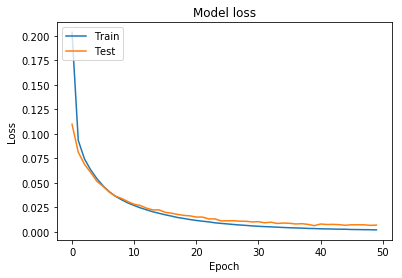

In [43]:
plot_model(history4)

## Conclusões
### - Algarismos Romanos + NN = EZ
### - ML is FUN kids